# This script is used to predict the Harpeth River heights based on the previous days heights and precipitation for the region. Both river data and precipitation data are from Kingston Springs, TN¶

## Naming conventions:
## Water - River data, heights
## Precip - Weather data, precipitation
## PredictWeather - Weather Predictions
## PredictWater - Predicted water data

### First section is used to import needed functions, connect to SQL DB, and get raw data

URL for data: https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00045=on&cb_00060=on&cb_00065=on&format=rdb&site_no=03433500&legacy=1&period=&begin_date=2021-02-10&end_date=2023-02-10

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
tf.random.set_seed(7)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


In [3]:
RiverData = pd.read_csv('C:\\Users\\ryder\\Desktop\\RiverPredictions\\HarpethBellevue.csv')

In [4]:
RiverDataCleaned = RiverData[['GaugeHeight', 'Precip']]

In [5]:
RiverDataCleaned.dropna(axis = 0, inplace = True)
#69861 rows × 2 columns
#About 5000 NA values, fix this before real analysis

D:\Anaconda\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [6]:
#Retrieved from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 """
 Frame a time series as a supervised learning dataset.
 Arguments:
 data: Sequence of observations as a list or NumPy array.
 n_in: Number of lag observations as input (X).
 n_out: Number of observations as output (y).
 dropnan: Boolean whether or not to drop rows with NaN values.
 Returns:
 Pandas DataFrame of series framed for supervised learning.
 """
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols, names = list(), list()
 
# input sequence (t-n, ... t-1)
 for i in range(n_in, -1, -1):
     cols.append(df.shift(i))
     names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]


 # put it all together
     agg = pd.concat(cols, axis=1)
     agg.columns = names
 # drop rows with NaN values
     if dropnan:
         agg.dropna(inplace=True)
 return agg


In [7]:
values = RiverDataCleaned.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')

# frame as supervised learning but adding lagging values as columns
reframed = series_to_supervised(values, 10, 1)

#Dreop column 21 as we are not predicting rainfall
reframed.drop(reframed.columns[[21]], axis=1, inplace=True)


In [8]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)


In [9]:
# split into train and test sets
n_train_quarterhours = 365 * 24 * 4
train = scaled[:n_train_quarterhours, :]
test = scaled[n_train_quarterhours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 1, 20) (35040,) (29504, 1, 20) (29504,)


In [73]:
# split into train and test sets
values = scaled
n_train_quarterhours = 365 * 24 * 4
train = values[:n_train_quarterhours, :]
test = values[n_train_quarterhours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35040, 1, 20) (35040,) (29504, 1, 20) (29504,)


In [18]:
#Import Model
model = tf.keras.models.load_model('LSTM.h5')

# Show the model architecture
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                14200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________


In [90]:
####Skip this part unless training new model
"""# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
""""

TypeError: add() got an unexpected keyword argument 'return_sequences'

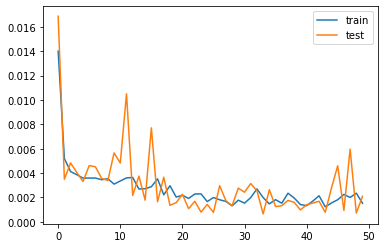

In [161]:
####Skip this part unless training new model
# save model and plot history
"""
model.save('LSTM.h5') 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
"""

In [12]:
#Reshape for predictions
test_X = test_X.reshape(29504, 1, 20)


#make predictions
yhat = model.predict(test_X)





922/922 [==============================] - 2s 2ms/step


In [13]:
#reshape yhat for concatenation with Test_X 
yhat = yhat.reshape(29504,1)
test_X = test_X.reshape(29504,20)
#concat predictions with Xtest data for inverse scaling
inv_yhat = np.concatenate((test_X, yhat), axis=1)

In [14]:
# invert scaling for forecast
inv_yhat = scaler.inverse_transform(inv_yhat)

In [15]:
#reshape actual y for concatenation with Test_X 
test_y = test_y.reshape(29504,1)

# invert scaling for actual
#concat actual y with Xtest data for inverse scaling
inv_y = np.concatenate((test_X, test_y), axis=1)

In [16]:
# invert scaling for forecast
inv_y = scaler.inverse_transform(inv_y)

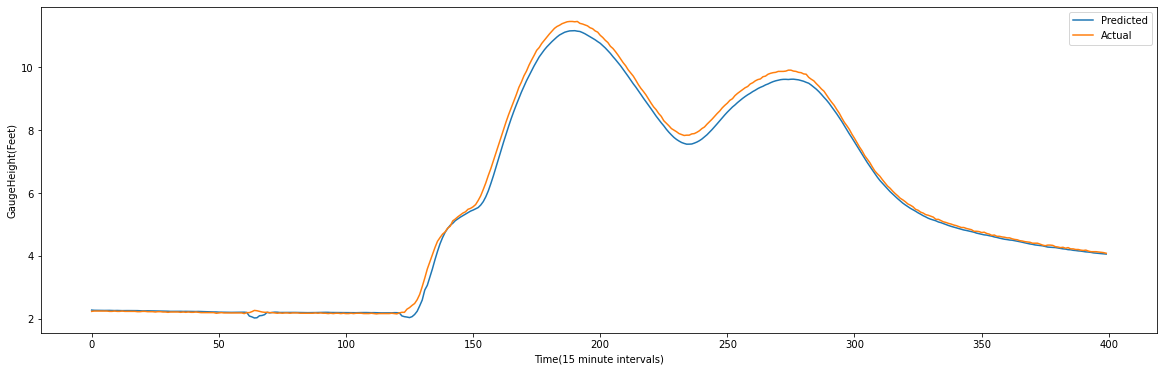

In [26]:
fig = plt.figure(figsize =(20, 6))
plt.plot(inv_yhat[25700:26100, 20], label='Predicted')
plt.plot(inv_y[25700:26100, 20], label='Actual')
plt.legend()
plt.ylabel('GaugeHeight(Feet)')
plt.xlabel('Time(15 minute intervals)')
plt.show()


In [248]:
rmse = math.sqrt(mean_squared_error(inv_y[:,20], inv_yhat[:,20]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.064


In [22]:
 ###The rest is experimental

In [64]:
#Number of 15 minute time steps to predict
Steps = 10
i = 0
#initialize predictions input
WaterPredicted = test_X[0:10]
#initialize predictions input and reshape for passing to TF
FitValues = test_X[0:1]
FitValues = FitValues.reshape(1,1,20)

In [69]:
#This is all wrong, redo it

while(i < Steps):
   
    #Pass parameters to model, predict W(t)
    yhatseq = model.predict_step(FitValues)
    yhatseq = yhatseq.reshape(1,1,1)
    np.append(FitValues, yhatseq, axis = 2) #Append T+1, now becomes T
    np.delete(FitValues, 0, axis = 0) #Delete first record, as that is now T-11
    
    
  
    i+=1

In [84]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
 # reshape input pattern to [samples, timesteps, features]
 X = X.reshape(1, 1, 20)
 # make forecast
 forecast = model.predict(X, batch_size=n_batch)
 # convert to array
 return [x for x in forecast[0, :]]

In [85]:
forecast_lstm(model, test_Xseq, 1)

1/1 [==============================] - 1s 654ms/step


[0.09019536]

In [88]:
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
 forecasts = list()
 for i in range(1):
     X, y = test[i, 0:n_lag], test[i, n_lag:]
     # make forecast
     forecast = forecast_lstm(model, X, n_batch)
     # store the forecast
     forecasts.append(forecast)
 return forecasts

In [89]:
# make forecasts
forecasts = make_forecasts(model, 1, test_Xseq, test_Xseq, 1, 3)

ValueError: cannot reshape array of size 1 into shape (1,1,20)

In [83]:
test_Xseq.shape

(1, 20)